In [3]:
# Importing the necessary libraries 
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis

import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # For enhanced data visualization

from ipywidgets import interact  # For interactivity

import scipy.stats as stats  # For statistical analysis
from sklearn.model_selection import train_test_split  # For splitting the data into training and testing sets
from sklearn.linear_model import LinearRegression  # For linear regression modeling
from sklearn.metrics import mean_squared_error  # For evaluating the model's performance
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
# Set visualization styles
sns.set_theme(style="whitegrid")
sns.set_palette("deep")
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14

# Load datasets
age_group_df = pd.read_excel('C:/Users/Olidia Lunga/Desktop/Data Science/Falcon/age_group.xlsx')
enrollment_df = pd.read_excel('C:/Users/Olidia Lunga/Desktop/Data Science/Falcon/enrolment.xlsx', header=1)  # Skip the title row
sixth_form_df = pd.read_excel('C:/Users/Olidia Lunga/Desktop/Data Science/Falcon/l6_u6gender.xlsx', header=1)  # Skip header row
pass_rate_df = pd.read_excel('C:/Users/Olidia Lunga/Desktop/Data Science/Falcon/pass_rate.xlsx', header=1)  # Skip title row

In [9]:
# Clean and prepare data
# Fix enrollment data column names
enrollment_df.columns = ['Year', 'Male', 'Female']
enrollment_df['Total'] = enrollment_df['Male'] + enrollment_df['Female']

# Fix sixth form data
sixth_form_df.columns = ['Year', 'L6_Male', 'L6_Female', 'U6_Male', 'U6_Female']
sixth_form_df['Total_L6'] = sixth_form_df['L6_Male'] + sixth_form_df['L6_Female']
sixth_form_df['Total_U6'] = sixth_form_df['U6_Male'] + sixth_form_df['U6_Female']
sixth_form_df['Total'] = sixth_form_df['Total_L6'] + sixth_form_df['Total_U6']

# Fix pass rate data column names
pass_rate_df.columns = ['Year', 'IGCSE', 'AS', 'A_Level']

# Determine integration year (when females first enrolled)
integration_year = enrollment_df[enrollment_df['Female'] > 0]['Year'].min()

# Add period column to all dataframes
enrollment_df['Period'] = enrollment_df['Year'].apply(
    lambda x: 'Post-Integration' if x >= integration_year else 'Pre-Integration')
age_group_df['Period'] = age_group_df['Year'].apply(
    lambda x: 'Post-Integration' if x >= integration_year else 'Pre-Integration')
sixth_form_df['Period'] = sixth_form_df['Year'].apply(
    lambda x: 'Post-Integration' if x >= integration_year else 'Pre-Integration')
pass_rate_df['Period'] = pass_rate_df['Year'].apply(
    lambda x: 'Post-Integration' if x >= integration_year else 'Pre-Integration')

# Display information
print(f"Gender integration at Falcon College began in {integration_year}")

Gender integration at Falcon College began in 2017


In [10]:
# 1. Summary statistics for enrollment data
print("\n=== ENROLLMENT SUMMARY STATISTICS ===")
enrollment_summary = enrollment_df.groupby('Period')[['Male', 'Female', 'Total']].agg(
    ['count', 'mean', 'std', 'min', 'max'])
print(enrollment_summary)

# 2. Summary statistics for age group data
print("\n=== AGE GROUP SUMMARY STATISTICS ===")
# Melt the age group data for easier analysis
age_melted = pd.melt(age_group_df, 
                    id_vars=['Year', 'Period', 'Total'],
                    value_vars=['U12', 'U13', 'U14', 'U15', 'U16', 'U17', 'U18', 'U19', 'U20', 'OPEN'],
                    var_name='Age_Group', value_name='Count')
age_summary = age_melted.groupby(['Period', 'Age_Group'])['Count'].agg(
    ['count', 'mean', 'std', 'min', 'max']).reset_index()
print(age_summary)

# 3. Summary statistics for sixth form data
print("\n=== SIXTH FORM SUMMARY STATISTICS ===")
sixth_form_summary = sixth_form_df.groupby('Period')[
    ['L6_Male', 'L6_Female', 'U6_Male', 'U6_Female', 'Total_L6', 'Total_U6', 'Total']
].agg(['count', 'mean', 'std', 'min', 'max'])
print(sixth_form_summary)

# 4. Summary statistics for pass rates
print("\n=== ACADEMIC PERFORMANCE SUMMARY STATISTICS ===")
pass_rate_summary = pass_rate_df.groupby('Period')[['IGCSE', 'AS', 'A_Level']].agg(
    ['count', 'mean', 'std', 'min', 'max'])
print(pass_rate_summary)


=== ENROLLMENT SUMMARY STATISTICS ===
                  Male                                  Female             \
                 count        mean        std  min  max  count       mean   
Period                                                                      
Post-Integration     7  360.571429   9.897090  347  374      7  86.142857   
Pre-Integration      6  425.000000  16.792856  396  441      6   0.000000   

                                     Total                                   
                        std min  max count        mean        std  min  max  
Period                                                                       
Post-Integration  52.023804  13  148     7  446.714286  53.571492  380  510  
Pre-Integration    0.000000   0    0     6  425.000000  16.792856  396  441  

=== AGE GROUP SUMMARY STATISTICS ===
              Period Age_Group  count       mean        std  min  max
0   Post-Integration      OPEN      7   0.142857   0.377964    0    1
1   Pos

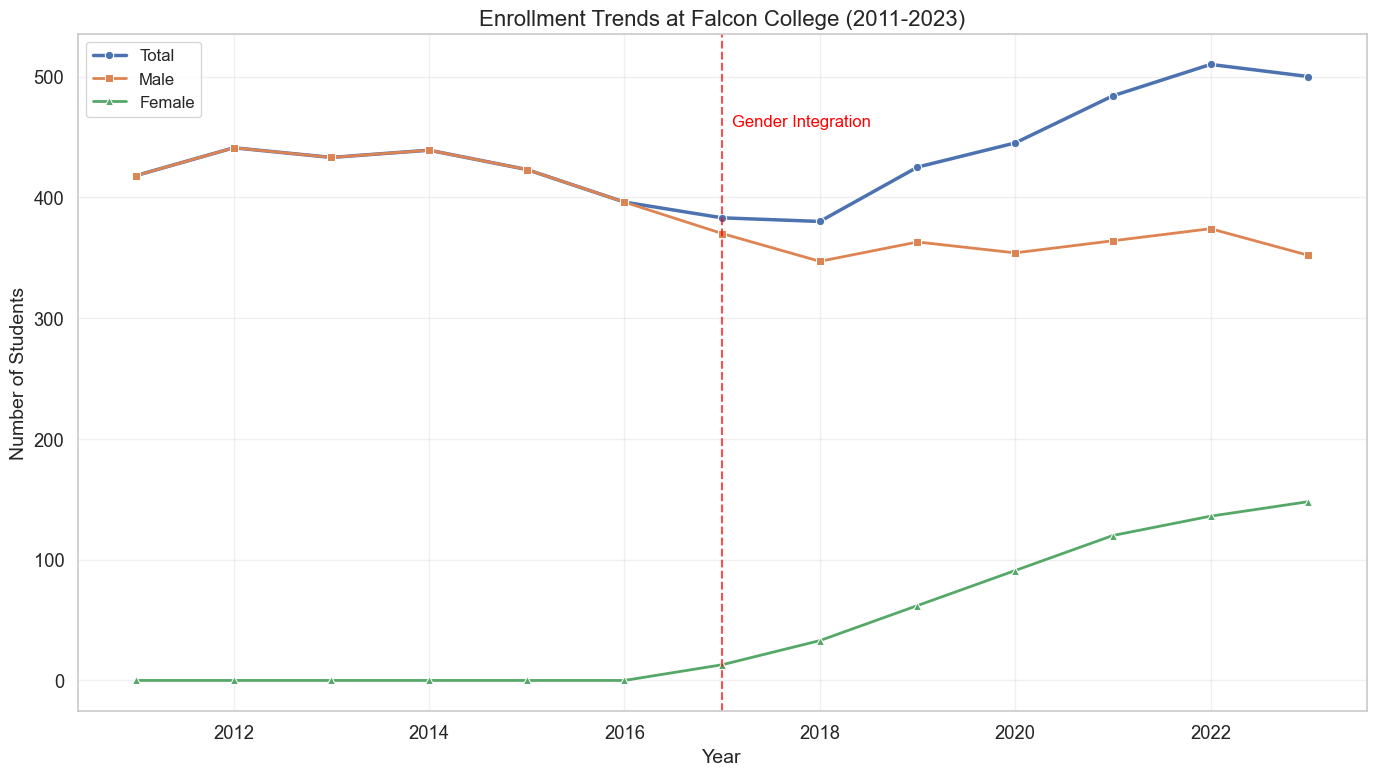

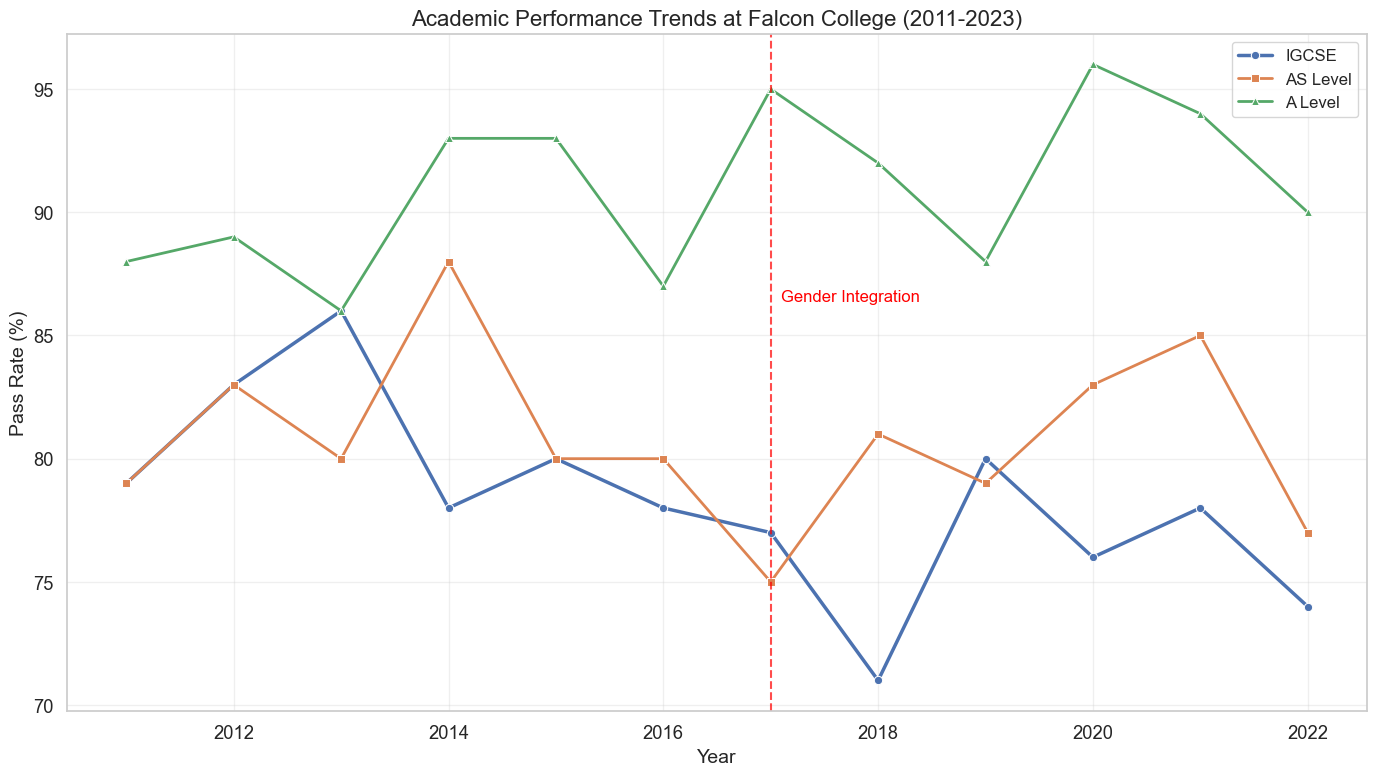

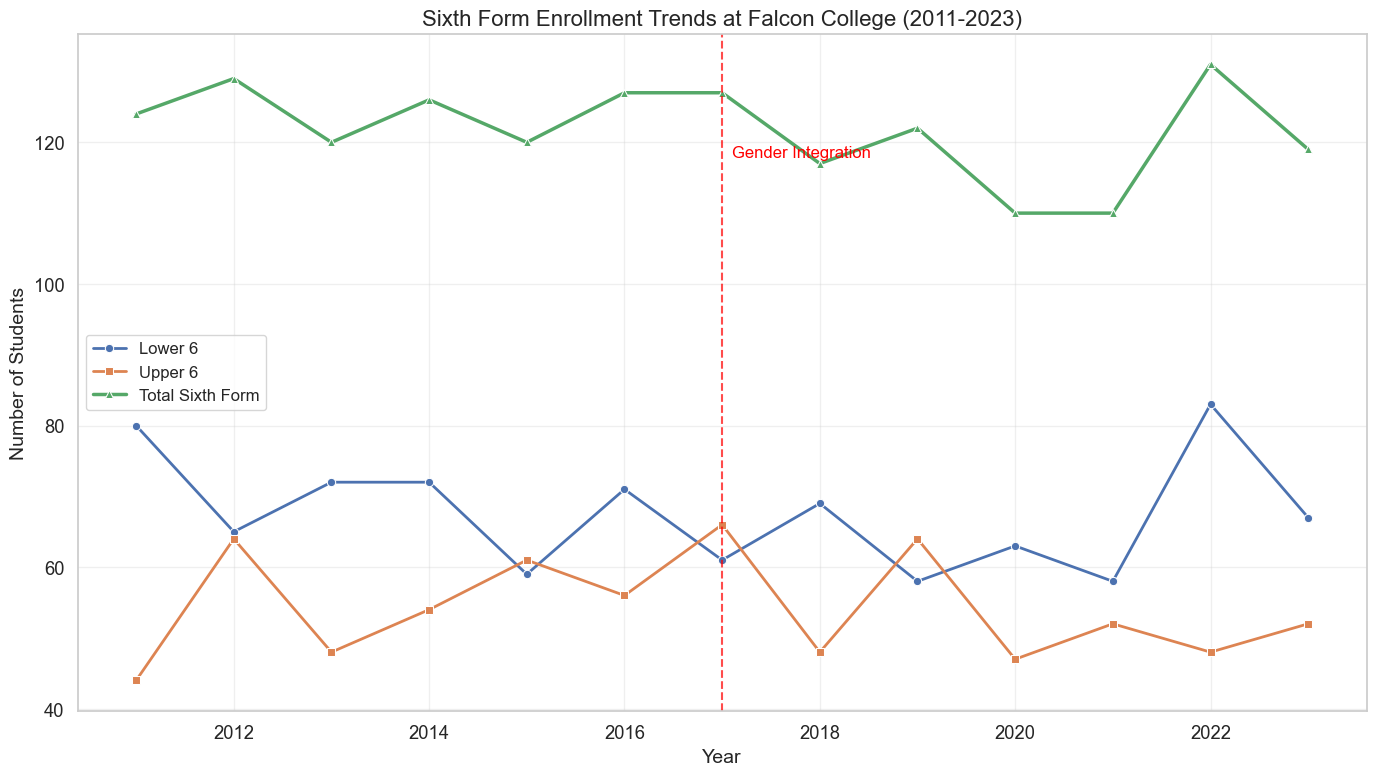

In [11]:
# Time Series Analysis: Enrollment Trends
plt.figure(figsize=(14, 8))
sns.lineplot(data=enrollment_df, x='Year', y='Total', marker='o', linewidth=2.5, label='Total')
sns.lineplot(data=enrollment_df, x='Year', y='Male', marker='s', linewidth=2, label='Male')
sns.lineplot(data=enrollment_df, x='Year', y='Female', marker='^', linewidth=2, label='Female')

plt.axvline(x=integration_year, color='red', linestyle='--', alpha=0.7)
plt.text(integration_year + 0.1, enrollment_df['Total'].max() * 0.9, 
         'Gender Integration', color='red', fontsize=12)

plt.title('Enrollment Trends at Falcon College (2011-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('enrollment_trends.png', dpi=300)
plt.show()

# Time Series Analysis: Pass Rates
plt.figure(figsize=(14, 8))
sns.lineplot(data=pass_rate_df, x='Year', y='IGCSE', marker='o', linewidth=2.5, label='IGCSE')
sns.lineplot(data=pass_rate_df, x='Year', y='AS', marker='s', linewidth=2, label='AS Level')
sns.lineplot(data=pass_rate_df, x='Year', y='A_Level', marker='^', linewidth=2, label='A Level')

plt.axvline(x=integration_year, color='red', linestyle='--', alpha=0.7)
plt.text(integration_year + 0.1, pass_rate_df[['IGCSE', 'AS', 'A_Level']].max().max() * 0.9, 
         'Gender Integration', color='red', fontsize=12)

plt.title('Academic Performance Trends at Falcon College (2011-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Pass Rate (%)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('pass_rate_trends.png', dpi=300)
plt.show()

# Time Series Analysis: Sixth Form Enrollment
plt.figure(figsize=(14, 8))
sns.lineplot(data=sixth_form_df, x='Year', y='Total_L6', marker='o', linewidth=2, label='Lower 6')
sns.lineplot(data=sixth_form_df, x='Year', y='Total_U6', marker='s', linewidth=2, label='Upper 6')
sns.lineplot(data=sixth_form_df, x='Year', y='Total', marker='^', linewidth=2.5, label='Total Sixth Form')

plt.axvline(x=integration_year, color='red', linestyle='--', alpha=0.7)
plt.text(integration_year + 0.1, sixth_form_df['Total'].max() * 0.9, 
         'Gender Integration', color='red', fontsize=12)

plt.title('Sixth Form Enrollment Trends at Falcon College (2011-2023)', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Students', fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=12)
plt.tight_layout()
plt.savefig('sixth_form_trends.png', dpi=300)
plt.show()

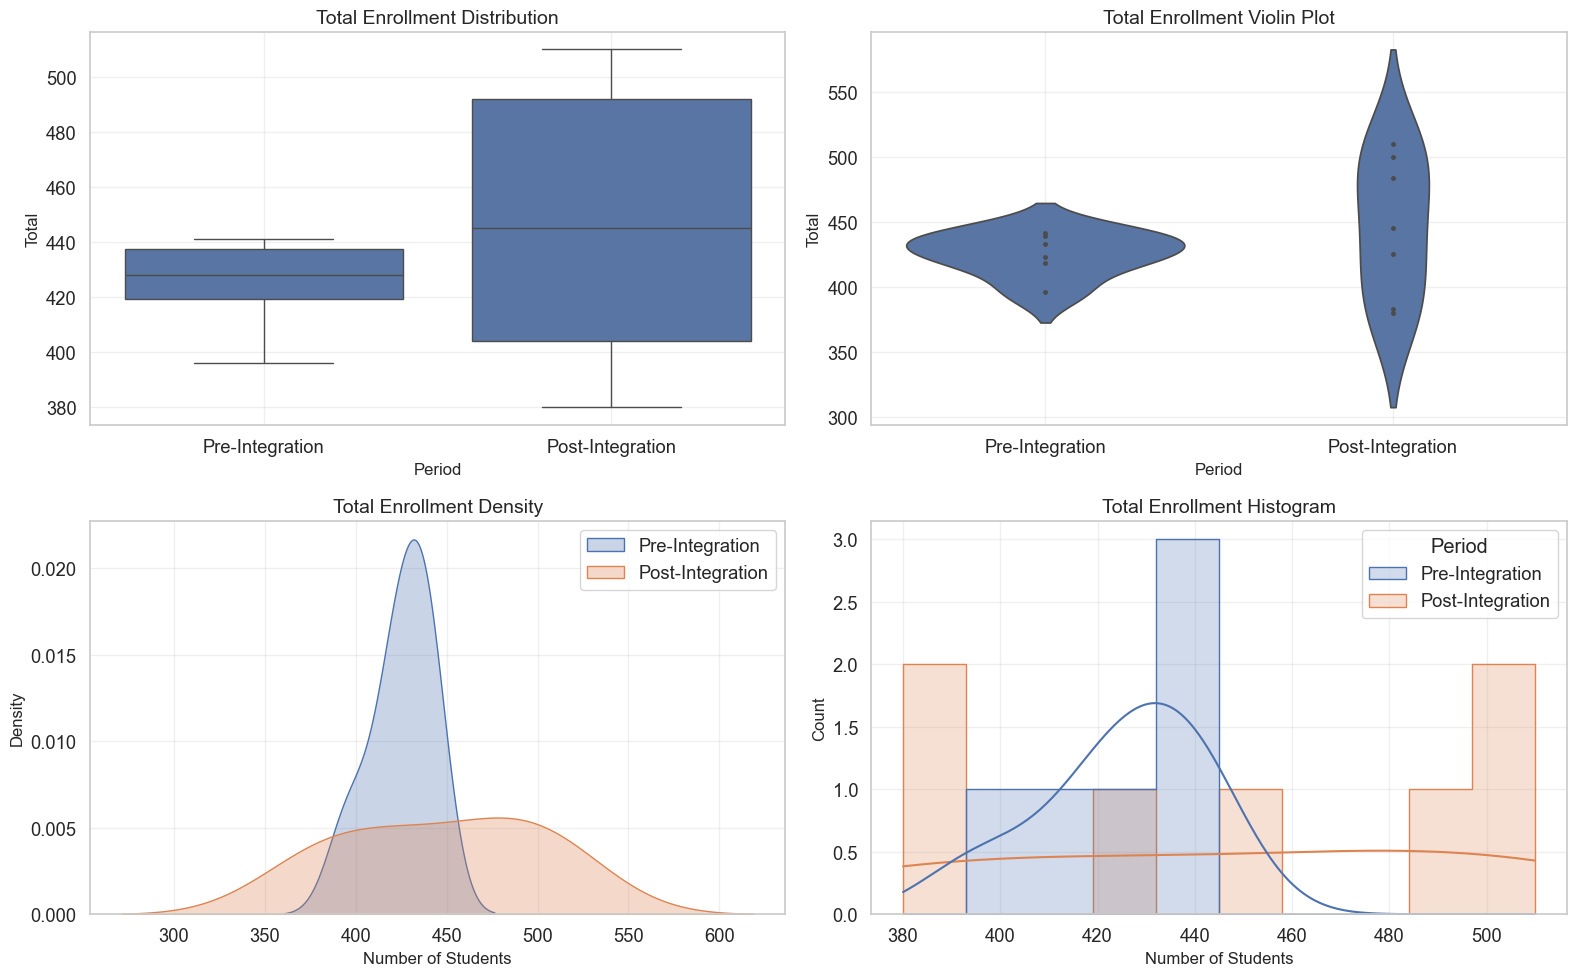

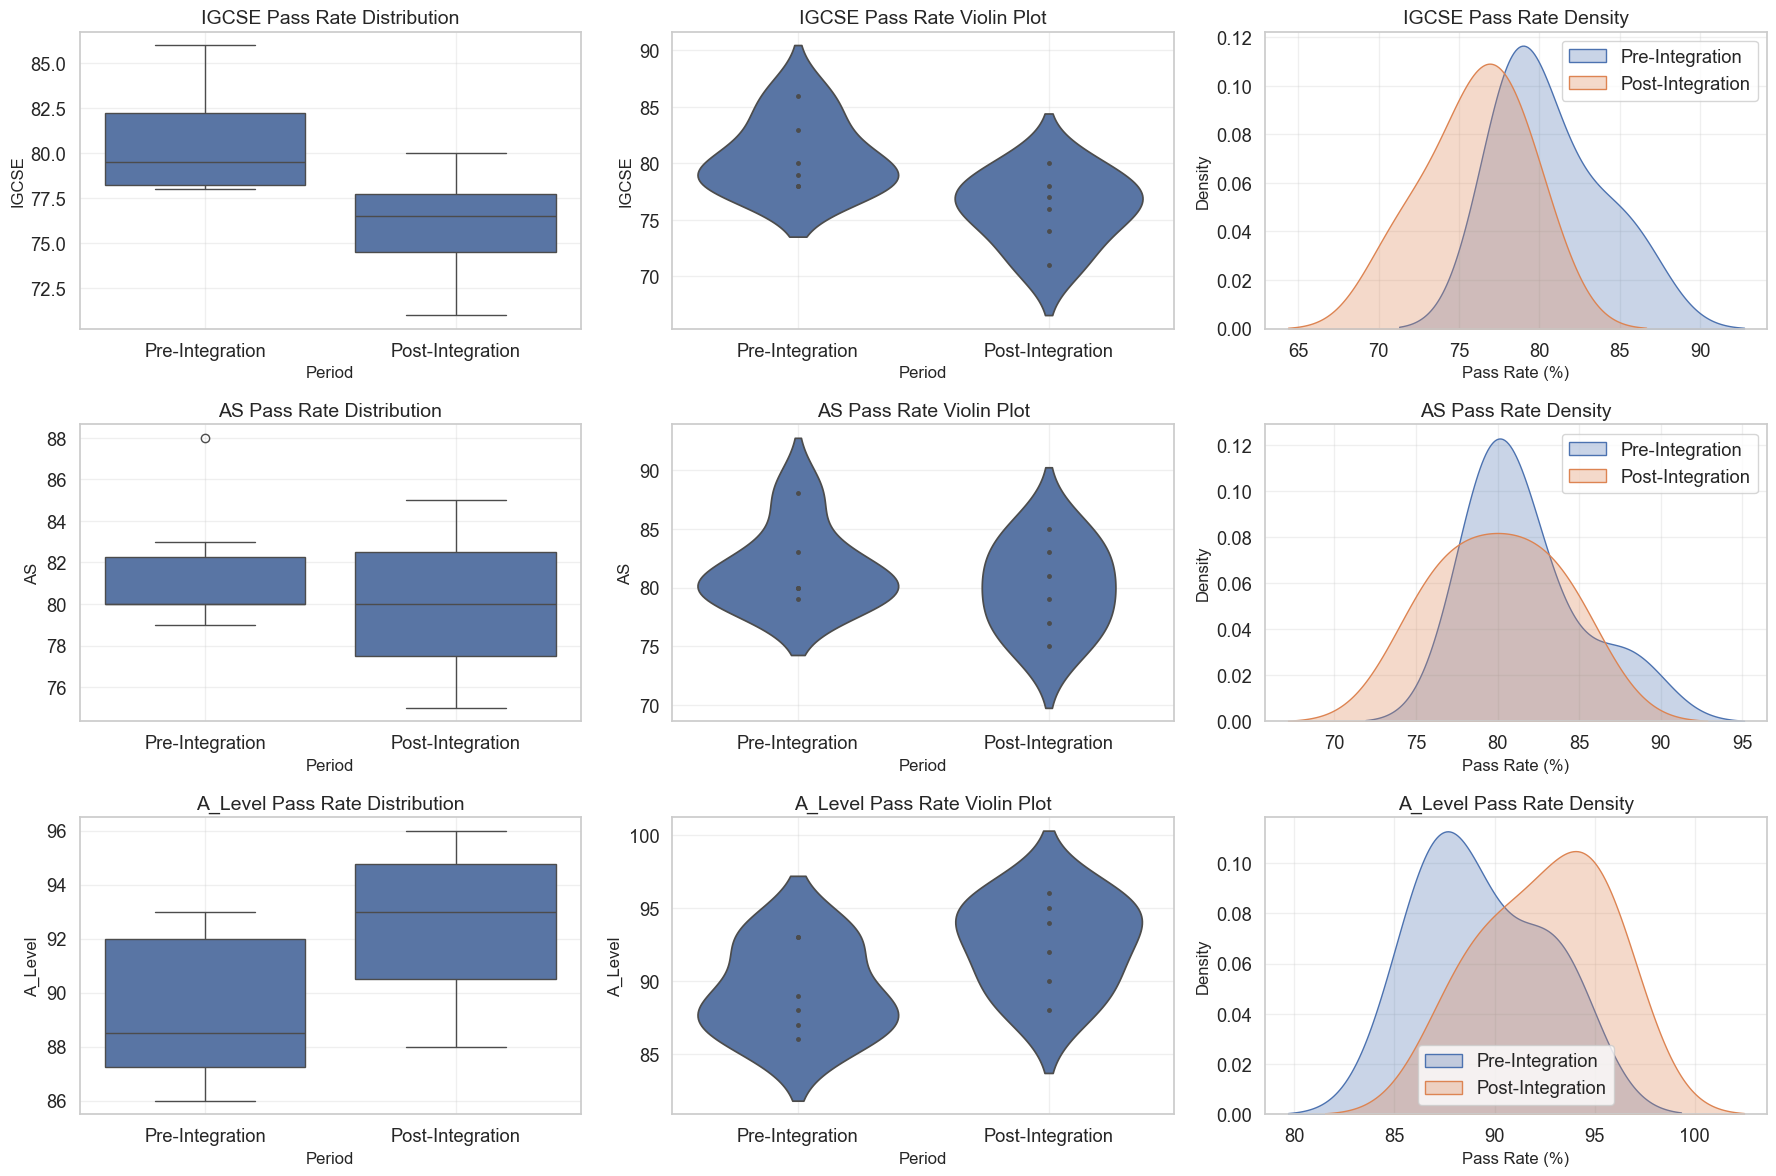

In [12]:
# Distribution Analysis: Enrollment
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
sns.boxplot(x='Period', y='Total', data=enrollment_df)
plt.title('Total Enrollment Distribution', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 2)
sns.violinplot(x='Period', y='Total', data=enrollment_df, inner='points')
plt.title('Total Enrollment Violin Plot', fontsize=14)
plt.grid(True, alpha=0.3)

plt.subplot(2, 2, 3)
for period in ['Pre-Integration', 'Post-Integration']:
    sns.kdeplot(enrollment_df[enrollment_df['Period'] == period]['Total'], 
               label=period, fill=True, alpha=0.3)
plt.title('Total Enrollment Density', fontsize=14)
plt.xlabel('Number of Students')
plt.grid(True, alpha=0.3)
plt.legend()

plt.subplot(2, 2, 4)
sns.histplot(data=enrollment_df, x='Total', hue='Period', element='step', 
            common_norm=False, bins=10, kde=True)
plt.title('Total Enrollment Histogram', fontsize=14)
plt.xlabel('Number of Students')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('enrollment_distribution.png', dpi=300)
plt.show()

# Distribution Analysis: Pass Rates
plt.figure(figsize=(18, 12))

for i, exam in enumerate(['IGCSE', 'AS', 'A_Level']):
    plt.subplot(3, 3, i*3 + 1)
    sns.boxplot(x='Period', y=exam, data=pass_rate_df)
    plt.title(f'{exam} Pass Rate Distribution', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, i*3 + 2)
    sns.violinplot(x='Period', y=exam, data=pass_rate_df, inner='points')
    plt.title(f'{exam} Pass Rate Violin Plot', fontsize=14)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, i*3 + 3)
    for period in ['Pre-Integration', 'Post-Integration']:
        sns.kdeplot(pass_rate_df[pass_rate_df['Period'] == period][exam], 
                   label=period, fill=True, alpha=0.3)
    plt.title(f'{exam} Pass Rate Density', fontsize=14)
    plt.xlabel('Pass Rate (%)')
    plt.grid(True, alpha=0.3)
    plt.legend()

plt.tight_layout()
plt.savefig('pass_rate_distribution.png', dpi=300)
plt.show()

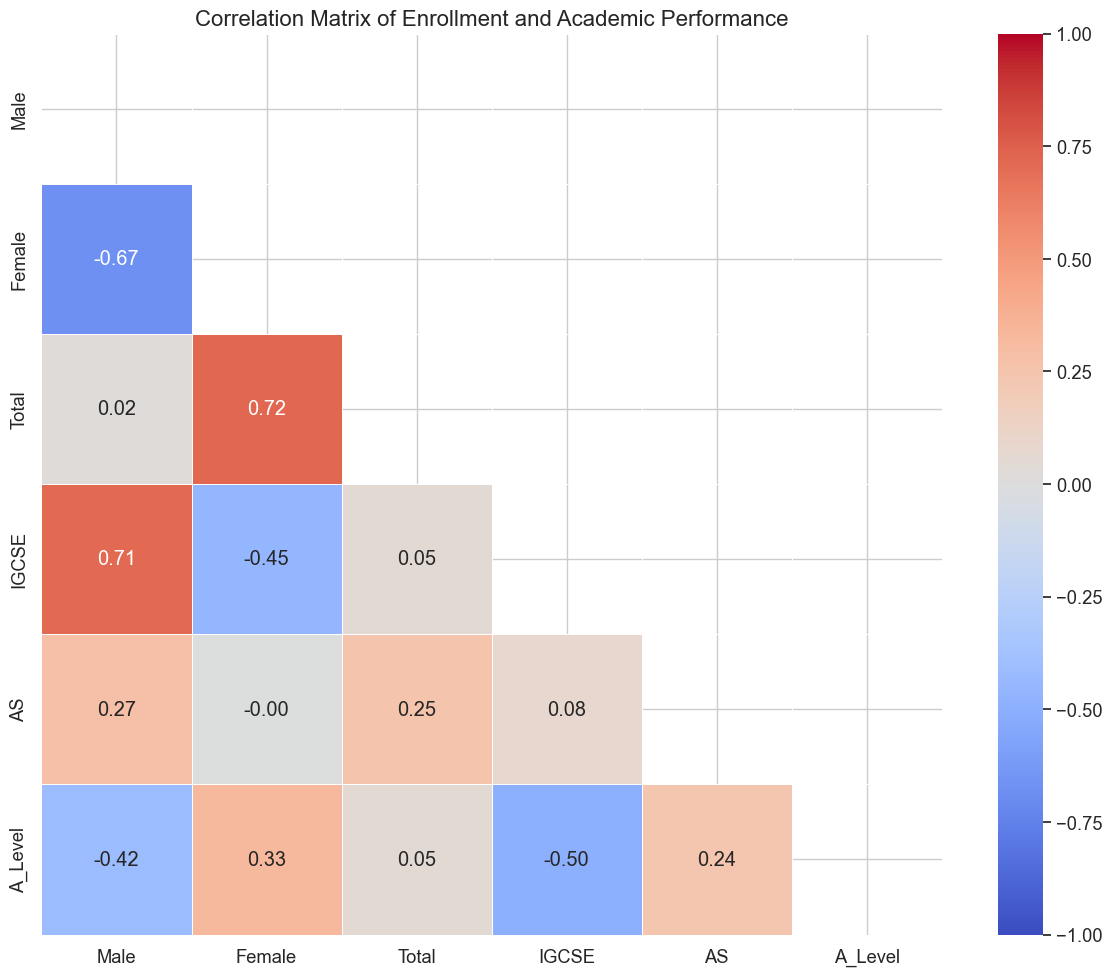

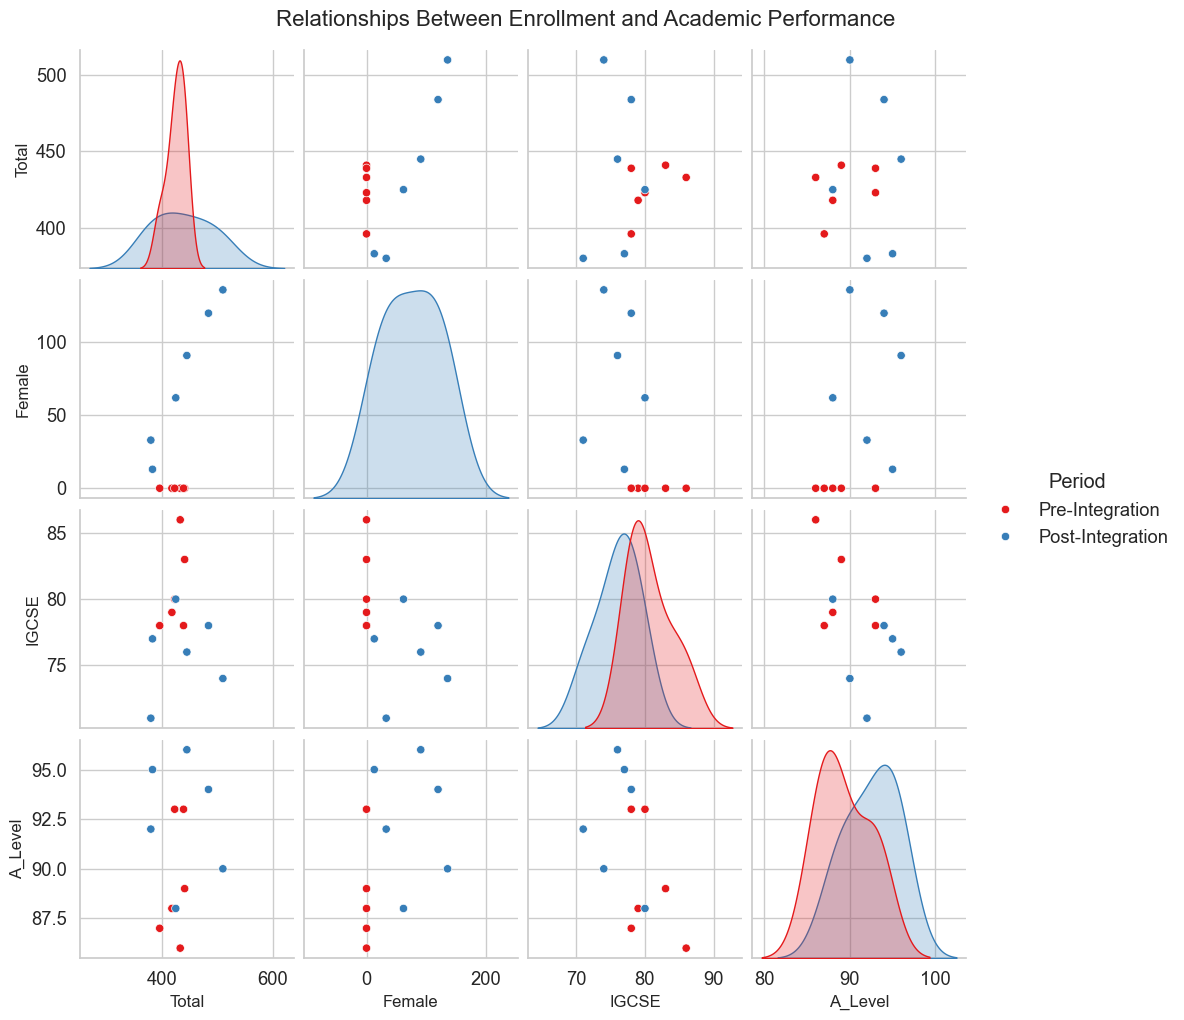

In [13]:
# Correlation Analysis
# Merge relevant dataframes for correlation analysis
# We'll create a merged dataset with enrollment and pass rates
merged_df = enrollment_df.merge(pass_rate_df, on=['Year', 'Period'])

# Calculate correlation matrix
correlation_matrix = merged_df[['Male', 'Female', 'Total', 'IGCSE', 'AS', 'A_Level']].corr()

# Visualize correlation matrix
plt.figure(figsize=(12, 10))
mask = np.triu(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
           mask=mask, vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix of Enrollment and Academic Performance', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300)
plt.show()

# Pairplot for key variables
sns.pairplot(merged_df[['Total', 'Female', 'IGCSE', 'A_Level', 'Period']], 
            hue='Period', palette='Set1', diag_kind='kde')
plt.suptitle('Relationships Between Enrollment and Academic Performance', 
            fontsize=16, y=1.02)
plt.savefig('pairplot.png', dpi=300)
plt.show()

In [14]:
# Statistical comparison of pre and post integration periods
print("\n=== STATISTICAL COMPARISON OF PRE VS POST INTEGRATION ===")

# Function to perform t-test and report results
def compare_periods(dataframe, variable, group_var='Period'):
    pre = dataframe[dataframe[group_var] == 'Pre-Integration'][variable]
    post = dataframe[dataframe[group_var] == 'Post-Integration'][variable]
    
    # Calculate basic statistics
    pre_mean = pre.mean()
    post_mean = post.mean()
    pre_std = pre.std()
    post_std = post.std()
    change = post_mean - pre_mean
    percent_change = (change / pre_mean * 100) if pre_mean != 0 else float('inf')
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(pre, post, equal_var=False)  # Welch's t-test
    
    # Calculate effect size (Cohen's d)
    pooled_std = np.sqrt(((len(pre) - 1) * pre_std**2 + (len(post) - 1) * post_std**2) / 
                        (len(pre) + len(post) - 2))
    effect_size = abs(pre_mean - post_mean) / pooled_std
    
    # Print results
    print(f"\n{variable} Comparison:")
    print(f"Pre-Integration Mean: {pre_mean:.2f}, Std: {pre_std:.2f}")
    print(f"Post-Integration Mean: {post_mean:.2f}, Std: {post_std:.2f}")
    print(f"Absolute Change: {change:.2f}")
    print(f"Percent Change: {percent_change:.2f}%")
    print(f"T-statistic: {t_stat:.3f}, P-value: {p_value:.4f}")
    print(f"Effect Size (Cohen's d): {effect_size:.3f}")
    
    # Interpret effect size
    if effect_size < 0.2:
        effect = "negligible"
    elif effect_size < 0.5:
        effect = "small"
    elif effect_size < 0.8:
        effect = "medium"
    else:
        effect = "large"
    
    # Interpret statistical significance
    if p_value < 0.05:
        significance = "statistically significant"
    else:
        significance = "not statistically significant"
        
    print(f"Interpretation: The difference is {significance} with a {effect} effect size.")
    
    return {
        'pre_mean': pre_mean,
        'post_mean': post_mean,
        'change': change,
        'percent_change': percent_change,
        'p_value': p_value,
        't_stat': t_stat,
        'effect_size': effect_size,
        'significant': p_value < 0.05,
        'effect_magnitude': effect
    }

# Perform statistical comparisons
enrollment_stats = compare_periods(enrollment_df, 'Total')
igcse_stats = compare_periods(pass_rate_df, 'IGCSE')
as_stats = compare_periods(pass_rate_df, 'AS')
alevel_stats = compare_periods(pass_rate_df, 'A_Level')
l6_stats = compare_periods(sixth_form_df, 'Total_L6')
u6_stats = compare_periods(sixth_form_df, 'Total_U6')

# Summary of findings
print("\n=== SUMMARY OF KEY FINDINGS ===")
print(f"1. Enrollment: {enrollment_stats['percent_change']:.2f}% change, p-value: {enrollment_stats['p_value']:.4f}, effect: {enrollment_stats['effect_magnitude']}")
print(f"2. IGCSE Pass Rate: {igcse_stats['percent_change']:.2f}% change, p-value: {igcse_stats['p_value']:.4f}, effect: {igcse_stats['effect_magnitude']}")
print(f"3. A Level Pass Rate: {alevel_stats['percent_change']:.2f}% change, p-value: {alevel_stats['p_value']:.4f}, effect: {alevel_stats['effect_magnitude']}")
print(f"4. Lower 6 Enrollment: {l6_stats['percent_change']:.2f}% change, p-value: {l6_stats['p_value']:.4f}, effect: {l6_stats['effect_magnitude']}")
print(f"5. Upper 6 Enrollment: {u6_stats['percent_change']:.2f}% change, p-value: {u6_stats['p_value']:.4f}, effect: {u6_stats['effect_magnitude']}")


=== STATISTICAL COMPARISON OF PRE VS POST INTEGRATION ===

Total Comparison:
Pre-Integration Mean: 425.00, Std: 16.79
Post-Integration Mean: 446.71, Std: 53.57
Absolute Change: 21.71
Percent Change: 5.11%
T-statistic: -1.016, P-value: 0.3421
Effect Size (Cohen's d): 0.528
Interpretation: The difference is not statistically significant with a medium effect size.

IGCSE Comparison:
Pre-Integration Mean: 80.67, Std: 3.20
Post-Integration Mean: 76.00, Std: 3.16
Absolute Change: -4.67
Percent Change: -5.79%
T-statistic: 2.539, P-value: 0.0294
Effect Size (Cohen's d): 1.466
Interpretation: The difference is statistically significant with a large effect size.

AS Comparison:
Pre-Integration Mean: 81.67, Std: 3.39
Post-Integration Mean: 80.00, Std: 3.74
Absolute Change: -1.67
Percent Change: -2.04%
T-statistic: 0.809, P-value: 0.4375
Effect Size (Cohen's d): 0.467
Interpretation: The difference is not statistically significant with a small effect size.

A_Level Comparison:
Pre-Integration Mea

In [15]:
# Enhanced Statistical Analysis with Clear Hypotheses and Interpretation

# Define a function for comprehensive hypothesis testing
def hypothesis_test(pre_data, post_data, metric_name, alpha=0.05):
    """
    Performs comprehensive hypothesis testing comparing pre and post integration data.
    
    Parameters:
    -----------
    pre_data : array-like
        Data from pre-integration period
    post_data : array-like
        Data from post-integration period
    metric_name : str
        Name of the metric being tested (for reporting)
    alpha : float
        Significance level (default 0.05)
        
    Returns:
    --------
    dict
        Dictionary containing test results and interpretation
    """
    results = {}
    
    # Calculate descriptive statistics
    pre_mean = np.mean(pre_data)
    post_mean = np.mean(post_data)
    pre_std = np.std(pre_data, ddof=1)
    post_std = np.std(post_data, ddof=1)
    
    # Calculate difference and percent change
    diff = post_mean - pre_mean
    percent_change = (diff / pre_mean * 100) if pre_mean != 0 else np.nan
    
    # Perform t-test (Welch's t-test for unequal variances)
    t_stat, p_value = stats.ttest_ind(pre_data, post_data, equal_var=False)
    
    # Calculate effect size (Cohen's d)
    # Pooled standard deviation formula
    n1, n2 = len(pre_data), len(post_data)
    pooled_std = np.sqrt(((n1 - 1) * pre_std**2 + (n2 - 1) * post_std**2) / 
                         (n1 + n2 - 2))
    
    # Cohen's d calculation
    cohens_d = abs(pre_mean - post_mean) / pooled_std
    
    # Calculate 95% confidence interval for the difference in means
    # Using Welch-Satterthwaite degrees of freedom
    dof = (pre_std**2/n1 + post_std**2/n2)**2 / ((pre_std**2/n1)**2/(n1-1) + (post_std**2/n2)**2/(n2-1))
    t_critical = stats.t.ppf(1 - alpha/2, dof)
    standard_error = np.sqrt(pre_std**2/n1 + post_std**2/n2)
    margin_of_error = t_critical * standard_error
    ci_lower = diff - margin_of_error
    ci_upper = diff + margin_of_error
    
    # Store results
    results['metric'] = metric_name
    results['pre_mean'] = pre_mean
    results['post_mean'] = post_mean
    results['pre_std'] = pre_std
    results['post_std'] = post_std
    results['difference'] = diff
    results['percent_change'] = percent_change
    results['t_statistic'] = t_stat
    results['p_value'] = p_value
    results['cohens_d'] = cohens_d
    results['ci_lower'] = ci_lower
    results['ci_upper'] = ci_upper
    results['dof'] = dof
    
    # Interpret effect size
    if cohens_d < 0.2:
        effect_size_interp = "negligible"
    elif cohens_d < 0.5:
        effect_size_interp = "small"
    elif cohens_d < 0.8:
        effect_size_interp = "medium"
    else:
        effect_size_interp = "large"
    
    results['effect_size_interpretation'] = effect_size_interp
    
    # Interpret statistical significance
    results['significant'] = p_value < alpha
    
    # Generate summary statement
    if p_value < alpha:
        sig_statement = f"There is a statistically significant difference in {metric_name} between pre and post integration periods (t({dof:.1f})={t_stat:.3f}, p={p_value:.4f})"
    else:
        sig_statement = f"There is no statistically significant difference in {metric_name} between pre and post integration periods (t({dof:.1f})={t_stat:.3f}, p={p_value:.4f})"
    
    direction = "increased" if diff > 0 else "decreased"
    effect_statement = f"The {direction} by {abs(percent_change):.2f}% with a {effect_size_interp} effect size (Cohen's d={cohens_d:.2f})"
    ci_statement = f"95% CI [{ci_lower:.2f}, {ci_upper:.2f}]"
    
    results['interpretation'] = f"{sig_statement}. {effect_statement}. {ci_statement}"
    
    return results

# Apply hypothesis testing to key metrics
print("=== HYPOTHESIS TESTING RESULTS ===\n")

# Define null and alternative hypotheses
print("Null Hypothesis (H0): There is no difference in metrics between pre and post gender integration periods")
print("Alternative Hypothesis (H1): There is a difference in metrics between pre and post gender integration periods\n")

# Test total enrollment
pre_enrollment = enrollment_df[enrollment_df['Period'] == 'Pre-Integration']['Total']
post_enrollment = enrollment_df[enrollment_df['Period'] == 'Post-Integration']['Total']
enrollment_test = hypothesis_test(pre_enrollment, post_enrollment, "Total Enrollment")
print(f"TOTAL ENROLLMENT:\n{enrollment_test['interpretation']}\n")

# Test IGCSE pass rates
pre_igcse = pass_rate_df[pass_rate_df['Period'] == 'Pre-Integration']['IGCSE']
post_igcse = pass_rate_df[pass_rate_df['Period'] == 'Post-Integration']['IGCSE']
igcse_test = hypothesis_test(pre_igcse, post_igcse, "IGCSE Pass Rate")
print(f"IGCSE PASS RATE:\n{igcse_test['interpretation']}\n")

# Test AS Level pass rates
pre_as = pass_rate_df[pass_rate_df['Period'] == 'Pre-Integration']['AS']
post_as = pass_rate_df[pass_rate_df['Period'] == 'Post-Integration']['AS']
as_test = hypothesis_test(pre_as, post_as, "AS Level Pass Rate")
print(f"AS LEVEL PASS RATE:\n{as_test['interpretation']}\n")

# Test A Level pass rates
pre_alevel = pass_rate_df[pass_rate_df['Period'] == 'Pre-Integration']['A_Level']
post_alevel = pass_rate_df[pass_rate_df['Period'] == 'Post-Integration']['A_Level']
alevel_test = hypothesis_test(pre_alevel, post_alevel, "A Level Pass Rate")
print(f"A LEVEL PASS RATE:\n{alevel_test['interpretation']}\n")

# Multi-factor ANOVA Analysis for Pass Rates
# Create a long-format dataframe for ANOVA
pass_rate_long = pd.melt(pass_rate_df, 
                         id_vars=['Year', 'Period'],
                         value_vars=['IGCSE', 'AS', 'A_Level'],
                         var_name='Exam_Type', value_name='Pass_Rate')

# Perform two-way ANOVA (factors: Period and Exam_Type)
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the model
model = ols('Pass_Rate ~ C(Period) + C(Exam_Type) + C(Period):C(Exam_Type)', data=pass_rate_long).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print("TWO-WAY ANOVA: EFFECTS OF PERIOD AND EXAM TYPE ON PASS RATES")
print(anova_table)
print("\nInterpretation:")
for factor, row in anova_table.iterrows():
    if row['PR(>F)'] < 0.05:
        print(f"- {factor} has a statistically significant effect on pass rates (p={row['PR(>F)']:.4f})")
    else:
        print(f"- {factor} does not have a statistically significant effect on pass rates (p={row['PR(>F)']:.4f})")

=== HYPOTHESIS TESTING RESULTS ===

Null Hypothesis (H0): There is no difference in metrics between pre and post gender integration periods
Alternative Hypothesis (H1): There is a difference in metrics between pre and post gender integration periods

TOTAL ENROLLMENT:
There is no statistically significant difference in Total Enrollment between pre and post integration periods (t(7.3)=-1.016, p=0.3421). The increased by 5.11% with a medium effect size (Cohen's d=0.53). 95% CI [-28.37, 71.79]

IGCSE PASS RATE:
There is a statistically significant difference in IGCSE Pass Rate between pre and post integration periods (t(10.0)=2.539, p=0.0294). The decreased by 5.79% with a large effect size (Cohen's d=1.47). 95% CI [-8.76, -0.57]

AS LEVEL PASS RATE:
There is no statistically significant difference in AS Level Pass Rate between pre and post integration periods (t(9.9)=0.809, p=0.4375). The decreased by 2.04% with a small effect size (Cohen's d=0.47). 95% CI [-6.26, 2.93]

A LEVEL PASS RAT

In [16]:
# Difference-in-Differences (DiD) Analysis
# This technique helps isolate the effect of gender integration by controlling for 
# time trends and other confounding factors

print("\n=== DIFFERENCE-IN-DIFFERENCES ANALYSIS ===\n")

# For DiD analysis, we'll use pass rates as the outcome and compare different exam types
# We'll consider IGCSE as the "control" group and A Level as the "treatment" group
# The "treatment" is gender integration

# Create a DiD dataframe
did_df = pass_rate_df.copy()
did_df['post_integration'] = (did_df['Period'] == 'Post-Integration').astype(int)

# Calculate means for DiD
pre_igcse_mean = did_df[(did_df['post_integration'] == 0)]['IGCSE'].mean()
post_igcse_mean = did_df[(did_df['post_integration'] == 1)]['IGCSE'].mean()
pre_alevel_mean = did_df[(did_df['post_integration'] == 0)]['A_Level'].mean()
post_alevel_mean = did_df[(did_df['post_integration'] == 1)]['A_Level'].mean()

# Calculate the DiD estimate
igcse_diff = post_igcse_mean - pre_igcse_mean
alevel_diff = post_alevel_mean - pre_alevel_mean
did_estimate = alevel_diff - igcse_diff

print(f"IGCSE Pass Rate Change: {igcse_diff:.2f} percentage points")
print(f"A Level Pass Rate Change: {alevel_diff:.2f} percentage points")
print(f"Difference-in-Differences Estimate: {did_estimate:.2f} percentage points\n")

# Regression-based DiD
# Create indicator variables for regression
did_long = pd.melt(did_df, 
                  id_vars=['Year', 'Period', 'post_integration'],
                  value_vars=['IGCSE', 'A_Level'],
                  var_name='exam_type', value_name='pass_rate')

did_long['is_alevel'] = (did_long['exam_type'] == 'A_Level').astype(int)
did_long['interaction'] = did_long['post_integration'] * did_long['is_alevel']

# Fit the DiD regression model
formula = 'pass_rate ~ post_integration + is_alevel + interaction'
did_model = ols(formula, data=did_long).fit()

print("REGRESSION-BASED DIFFERENCE-IN-DIFFERENCES ANALYSIS:")
print(did_model.summary().tables[1])

print("\nInterpretation:")
print(f"- The interaction coefficient ({did_model.params['interaction']:.2f}) represents the DiD estimate")
print(f"- P-value: {did_model.pvalues['interaction']:.4f}")
if did_model.pvalues['interaction'] < 0.05:
    print("- The effect of gender integration on A Level performance compared to IGCSE is statistically significant")
else:
    print("- The effect of gender integration on A Level performance compared to IGCSE is not statistically significant")

# Regression Discontinuity Design (RDD)
# For RDD, we'll use the integration year as our cutoff
print("\n=== REGRESSION DISCONTINUITY DESIGN ===\n")

# Create centered year variable
centered_df = pass_rate_df.copy()
centered_df['centered_year'] = centered_df['Year'] - integration_year

# Split data for visualization
pre_rdd = centered_df[centered_df['centered_year'] < 0]
post_rdd = centered_df[centered_df['centered_year'] >= 0]

# Fit pre and post models for A Level pass rates
pre_model = ols('A_Level ~ centered_year', data=pre_rdd).fit()
post_model = ols('A_Level ~ centered_year', data=post_rdd).fit()

# RDD estimate (difference at the cutoff)
rdd_estimate = post_model.params['Intercept'] - pre_model.params['Intercept']

print(f"RDD Estimate for A Level Pass Rate: {rdd_estimate:.2f} percentage points")
print(f"Pre-Integration Slope: {pre_model.params['centered_year']:.2f}")
print(f"Post-Integration Slope: {post_model.params['centered_year']:.2f}")

# Predictive Modeling for Future Trends
print("\n=== PREDICTIVE MODELING FOR FUTURE TRENDS ===\n")

# We'll use time series analysis to forecast enrollment trends
from statsmodels.tsa.arima.model import ARIMA

# Prepare time series data for enrollment
ts_df = enrollment_df.set_index('Year')
ts_data = ts_df['Total']

# Fit ARIMA model
model = ARIMA(ts_data, order=(1, 1, 1))
model_fit = model.fit()

# Forecast 5 years into the future
forecast_years = 5
forecast = model_fit.forecast(steps=forecast_years)
forecast_years_index = range(ts_data.index[-1] + 1, ts_data.index[-1] + forecast_years + 1)

print(f"Total Enrollment Forecast for the Next {forecast_years} Years:")
for year, value in zip(forecast_years_index, forecast):
    print(f"Year {year}: {value:.0f} students")

# Calculate forecast confidence intervals
forecast_ci = model_fit.get_forecast(steps=forecast_years).conf_int()
forecast_ci.index = forecast_years_index

# Calculate percentage of female students over time
if 'Female' in ts_df.columns and 'Total' in ts_df.columns:
    ts_df['Female_Percentage'] = (ts_df['Female'] / ts_df['Total'] * 100).fillna(0)
    
    # Fit model to female percentage data
    female_pct_data = ts_df['Female_Percentage'].iloc[ts_df.index >= integration_year]
    
    if len(female_pct_data) >= 3:  # Need at least 3 points for ARIMA
        female_model = ARIMA(female_pct_data, order=(1, 0, 0))
        female_model_fit = female_model.fit()
        
        # Forecast female percentage
        female_forecast = female_model_fit.forecast(steps=forecast_years)
        
        print("\nFemale Percentage Forecast:")
        for year, value in zip(forecast_years_index, female_forecast):
            print(f"Year {year}: {value:.1f}%")


=== DIFFERENCE-IN-DIFFERENCES ANALYSIS ===

IGCSE Pass Rate Change: -4.67 percentage points
A Level Pass Rate Change: 3.17 percentage points
Difference-in-Differences Estimate: 7.83 percentage points

REGRESSION-BASED DIFFERENCE-IN-DIFFERENCES ANALYSIS:
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           80.6667      1.272     63.416      0.000      78.013      83.320
post_integration    -4.6667      1.799     -2.594      0.017      -8.419      -0.914
is_alevel            8.6667      1.799      4.818      0.000       4.914      12.419
interaction          7.8333      2.544      3.079      0.006       2.527      13.140

Interpretation:
- The interaction coefficient (7.83) represents the DiD estimate
- P-value: 0.0059
- The effect of gender integration on A Level performance compared to IGCSE is statistically significant

=== REGRESSION DISCONTINUITY 

C:\Users\Olidia Lunga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Olidia Lunga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Olidia Lunga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\Olidia Lunga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\Olidia Lunga\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported ind

In [19]:
# 3.1 Visualization Best Practices
# Define a consistent color palette and style

# Set a consistent color palette for all visualizations
colors = {
    'Primary': '#1f77b4',            # Main color for primary series
    'Secondary': '#ff7f0e',          # Secondary color for comparison
    'Male': '#2166ac',               # Blue for male data
    'Female': '#b2182b',             # Red for female data
    'Pre-Integration': '#4393c3',    # Light blue for pre-integration
    'Post-Integration': '#d6604d',   # Light red for post-integration
    'IGCSE': '#4daf4a',              # Green for IGCSE
    'AS': '#984ea3',                 # Purple for AS
    'A_Level': '#ff7f00',            # Orange for A Level
    'Highlight': '#e41a1c',          # Red for highlights/integration year
    'Background': '#f7f7f7',         # Light gray for backgrounds
    'Grid': '#cccccc'                # Gray for grid lines
}

# Set style globally
plt.style.use('seaborn')
sns.set_theme(style="whitegrid", palette="deep")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 16

# Function to apply consistent styling to all plots
def style_plot(ax, title, xlabel, ylabel, legend_title=None, add_annotations=True):
    """Apply consistent styling to matplotlib axes"""
    ax.set_title(title, fontsize=14, pad=20)
    ax.set_xlabel(xlabel, fontsize=12, labelpad=10)
    ax.set_ylabel(ylabel, fontsize=12, labelpad=10)
    
    # Style the grid
    ax.grid(True, alpha=0.3, linestyle='--')
    
    # Add legend if there are multiple data series
    if legend_title and len(ax.get_legend_handles_labels()[0]) > 0:
        ax.legend(title=legend_title, frameon=True, framealpha=0.9)
    
    # Add integration year reference line if appropriate
    if add_annotations and 'Year' in xlabel:
        ax.axvline(x=integration_year, color=colors['Highlight'], 
                  linestyle='--', alpha=0.7, linewidth=1.5)
        ax.text(integration_year + 0.1, ax.get_ylim()[1] * 0.95, 
                'Gender Integration', color=colors['Highlight'], 
                fontsize=10, ha='left', va='top',
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))
    
    # Improve tick appearance
    ax.tick_params(axis='both', which='major', labelsize=10)
    
    # Add a subtle background color
    ax.set_facecolor(colors['Background'])
    
    return ax

# 3.2 Enhanced Visualizations

# 1. Before/After Comparison Charts
print("\nCreating enhanced before/after comparison visualizations...")

# Enrollment comparison before/after
plt.figure(figsize=(14, 10))

# Chart 1: Total Enrollment comparison
plt.subplot(2, 2, 1)
sns.barplot(data=enrollment_df, x='Period', y='Total', 
           palette={'Pre-Integration': colors['Pre-Integration'], 
                    'Post-Integration': colors['Post-Integration']})
ax = plt.gca()
style_plot(ax, 'Average Total Enrollment: Pre vs Post Integration', 
          'Period', 'Number of Students', add_annotations=False)

# Add mean value labels on bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 5, f'{height:.1f}',
            ha='center', fontsize=10, fontweight='bold')

# Chart 2: Pass rates comparison
plt.subplot(2, 2, 2)
pass_comparison = pass_rate_df.groupby('Period')[['IGCSE', 'AS', 'A_Level']].mean().reset_index()
pass_comparison_long = pd.melt(pass_comparison, id_vars=['Period'], 
                             value_vars=['IGCSE', 'AS', 'A_Level'],
                             var_name='Exam_Type', value_name='Pass_Rate')

sns.barplot(data=pass_comparison_long, x='Exam_Type', y='Pass_Rate', hue='Period',
           palette={'Pre-Integration': colors['Pre-Integration'], 
                    'Post-Integration': colors['Post-Integration']})
ax = plt.gca()
style_plot(ax, 'Average Pass Rates: Pre vs Post Integration', 
          'Exam Type', 'Pass Rate (%)', legend_title='Period', add_annotations=False)

# Add value labels on bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1, f'{height:.1f}%',
            ha='center', fontsize=9, fontweight='bold')

# Chart 3: Sixth Form comparison
plt.subplot(2, 2, 3)
sixth_comparison = sixth_form_df.groupby('Period')[['Total_L6', 'Total_U6']].mean().reset_index()
sixth_comparison_long = pd.melt(sixth_comparison, id_vars=['Period'], 
                              value_vars=['Total_L6', 'Total_U6'],
                              var_name='Form', value_name='Students')

sns.barplot(data=sixth_comparison_long, x='Form', y='Students', hue='Period',
           palette={'Pre-Integration': colors['Pre-Integration'], 
                    'Post-Integration': colors['Post-Integration']})
ax = plt.gca()
style_plot(ax, 'Average Sixth Form Enrollment: Pre vs Post Integration', 
          'Form Level', 'Number of Students', legend_title='Period', add_annotations=False)

# Add value labels on bars
for i, p in enumerate(ax.patches):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2., height + 1, f'{height:.1f}',
            ha='center', fontsize=9, fontweight='bold')

# Chart 4: Gender distribution post-integration
plt.subplot(2, 2, 4)
post_gender = enrollment_df[enrollment_df['Period'] == 'Post-Integration'].copy()
post_gender['Male_Percent'] = post_gender['Male'] / post_gender['Total'] * 100
post_gender['Female_Percent'] = post_gender['Female'] / post_gender['Total'] * 100
post_gender_long = pd.melt(post_gender, id_vars=['Year'], 
                         value_vars=['Male_Percent', 'Female_Percent'],
                         var_name='Gender', value_name='Percentage')
post_gender_long['Gender'] = post_gender_long['Gender'].str.replace('_Percent', '')

sns.lineplot(data=post_gender_long, x='Year', y='Percentage', hue='Gender',
            palette={'Male': colors['Male'], 'Female': colors['Female']},
            markers=True, linewidth=2.5)
ax = plt.gca()
style_plot(ax, 'Gender Distribution After Integration', 
          'Year', 'Percentage of Students (%)', legend_title='Gender', add_annotations=False)

plt.tight_layout(pad=3.0)
plt.savefig('before_after_comparison.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Performance Trends Over Time with Enhanced Styling
plt.figure(figsize=(14, 8))

# Main performance trend plot
sns.lineplot(data=pass_rate_df, x='Year', y='IGCSE', 
           color=colors['IGCSE'], marker='o', linewidth=2.5, label='IGCSE')
sns.lineplot(data=pass_rate_df, x='Year', y='AS', 
           color=colors['AS'], marker='s', linewidth=2.5, label='AS Level')
sns.lineplot(data=pass_rate_df, x='Year', y='A_Level'), 
           color=colors['A_Level'], marker='^', linewidth=2.5, label='A Level')

ax = plt.gca()
style_plot(ax, 'Academic Performance Trends (2011-2023)', 
          'Year', 'Pass Rate (%)', legend_title='Exam Type')

# Add annotations for key points
# Find maximum and minimum points for each exam type
for exam_type, color in zip(['IGCSE', 'AS', 'A_Level'], 
                           [colors['IGCSE'], colors['AS'], colors['A_Level']]):
    # Max point
    max_idx = pass_rate_df[exam_type].idxmax()
    max_year = pass_rate_df.loc[max_idx, 'Year']
    max_value = pass_rate_df.loc[max_idx, exam_type]
    
    ax.annotate(f'{max_value}%', 
               xy=(max_year, max_value), 
               xytext=(max_year, max_value + 3),
               color=color,
               fontsize=9,
               fontweight='bold',
               ha='center',
               arrowprops=dict(arrowstyle='->', color=color))
    
    # Min point
    min_idx = pass_rate_df[exam_type].idxmin()
    min_year = pass_rate_df.loc[min_idx, 'Year']
    min_value = pass_rate_df.loc[min_idx, exam_type]
    
    ax.annotate(f'{min_value}%', 
               xy=(min_year, min_value), 
               xytext=(min_year, min_value - 5),
               color=color,
               fontsize=9,
               fontweight='bold',
               ha='center',
               arrowprops=dict(arrowstyle='->', color=color))

plt.tight_layout()
plt.savefig('performance_trends.png', dpi=300, bbox_inches='tight')
plt.close()

# 3. Enrollment Composition Over Time (Stacked Area Chart)
plt.figure(figsize=(14, 8))

# Create data for stacking
stack_df = enrollment_df.copy()
stack_df = stack_df[['Year', 'Male', 'Female']]

# Plot stacked area chart
plt.stackplot(stack_df['Year'], stack_df['Male'], stack_df['Female'],
             labels=['Male', 'Female'],
             colors=[colors['Male'], colors['Female']], alpha=0.8)

ax = plt.gca()
style_plot(ax, 'Student Enrollment Composition by Gender (2011-2023)', 
          'Year', 'Number of Students', legend_title='Gender')

# Add total enrollment line
plt.plot(stack_df['Year'], stack_df['Male'] + stack_df['Female'], 
         color='black', linestyle='-', linewidth=2, label='Total')

# Add labels for beginning and end
start_total = stack_df.iloc[0]['Male'] + stack_df.iloc[0]['Female']
end_total = stack_df.iloc[-1]['Male'] + stack_df.iloc[-1]['Female']

plt.annotate(f'Total: {int(start_total)}', 
             xy=(stack_df.iloc[0]['Year'], start_total),
             xytext=(stack_df.iloc[0]['Year'], start_total + 20),
             fontsize=10, fontweight='bold', ha='left',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.annotate(f'Total: {int(end_total)}', 
             xy=(stack_df.iloc[-1]['Year'], end_total),
             xytext=(stack_df.iloc[-1]['Year'], end_total + 20),
             fontsize=10, fontweight='bold', ha='right',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('enrollment_composition.png', dpi=300, bbox_inches='tight')
plt.close()

# 4. Statistical Significance Visualization with Confidence Intervals
plt.figure(figsize=(14, 10))

# Create dataframe for plotting
stat_results = pd.DataFrame([
    enrollment_test,
    igcse_test,
    as_test, 
    alevel_test
])

# Plot 1: Mean differences with CIs
plt.subplot(2, 1, 1)
metrics = stat_results['metric'].tolist()
diffs = stat_results['difference'].tolist()
ci_lower = stat_results['ci_lower'].tolist()
ci_upper = stat_results['ci_upper'].tolist()
p_values = stat_results['p_value'].tolist()

# Error bars (95% CI)
error_bars = [(u - d, l - d) for d, l, u in zip(diffs, ci_lower, ci_upper)]
error_high = [e[0] for e in error_bars]
error_low = [e[1] for e in error_bars]

# Create bar colors based on significance
bar_colors = [colors['Post-Integration'] if p < 0.05 else 'gray' for p in p_values]

x_pos = np.arange(len(metrics))
bars = plt.bar(x_pos, diffs, yerr=[error_low, error_high], align='center', 
              capsize=10, color=bar_colors, alpha=0.7)

# Add zero line
plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)

# Label axes
plt.ylabel('Difference (Post - Pre)', fontsize=12)
plt.xticks(x_pos, metrics, rotation=45, ha='right')
plt.title('Mean Differences with 95% Confidence Intervals', fontsize=14)

# Add significance annotations
for i, p in enumerate(p_values):
    y_pos = diffs[i] + error_high[i] + 2
    if p < 0.05:
        plt.text(x_pos[i], y_pos, '*', fontsize=24, ha='center', va='bottom')
        plt.text(x_pos[i], y_pos + 3, f'p={p:.3f}', fontsize=10, ha='center', va='bottom')
    else:
        plt.text(x_pos[i], y_pos, 'ns', fontsize=12, ha='center', va='bottom')
        plt.text(x_pos[i], y_pos + 3, f'p={p:.3f}', fontsize=10, ha='center', va='bottom')

IndentationError: unexpected indent (1517055639.py, line 158)

NameError: name 'stat_results' is not defined

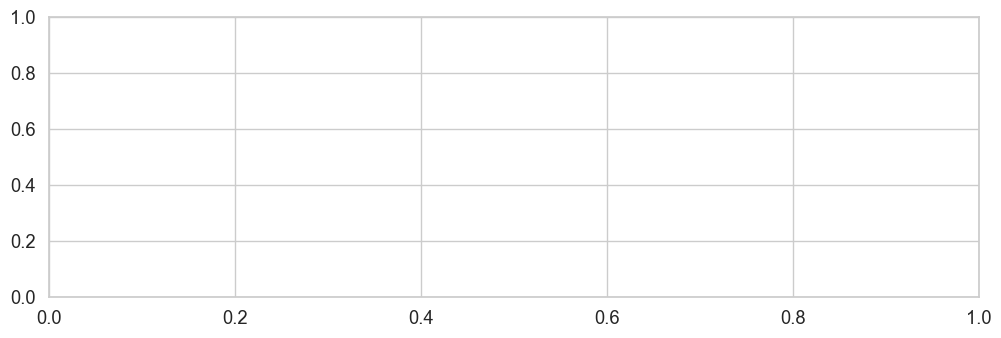

In [20]:
# Plot 2: Effect sizes
plt.subplot(2, 1, 2)
effect_sizes = stat_results['cohens_d'].tolist()
effect_labels = stat_results['effect_size_interpretation'].tolist()

bars = plt.bar(x_pos, effect_sizes, align='center', color=bar_colors, alpha=0.7)

# Add reference lines for effect size interpretation
plt.axhline(y=0.2, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(y=0.5, color='gray', linestyle='--', linewidth=1, alpha=0.7)
plt.axhline(y=0.8, color='gray', linestyle='--', linewidth=1, alpha=0.7)

plt.text(x_pos[-1] + 0.5, 0.1, 'Negligible', fontsize=9, ha='left', va='center')
plt.text(x_pos[-1] + 0.5, 0.35, 'Small', fontsize=9, ha='left', va='center')
plt.text(x_pos[-1] + 0.5, 0.65, 'Medium', fontsize=9, ha='left', va='center')
plt.text(x_pos[-1] + 0.5, 1.0, 'Large', fontsize=9, ha='left', va='center')

# Label axes
plt.ylabel("Effect Size (Cohen's d)", fontsize=12)
plt.xticks(x_pos, metrics, rotation=45, ha='right')
plt.title('Effect Sizes (Cohen\'s d)', fontsize=14)

# Add effect size labels
for i, es in enumerate(effect_sizes):
    plt.text(x_pos[i], es + 0.05, f'{es:.2f}', fontsize=10, ha='center')
    plt.text(x_pos[i], es - 0.15, effect_labels[i], fontsize=9, ha='center', rotation=90)

plt.tight_layout()
plt.savefig('statistical_significance.png', dpi=300, bbox_inches='tight')
plt.close()

# 5. Heatmap for Correlation Analysis
plt.figure(figsize=(12, 10))

# Create a merged dataframe for correlation analysis
corr_df = enrollment_df.merge(pass_rate_df, on=['Year', 'Period'])
corr_df = corr_df.merge(sixth_form_df[['Year', 'Total_L6', 'Total_U6']], on='Year')

# Select numeric columns for correlation
corr_columns = ['Male', 'Female', 'Total', 'IGCSE', 'AS', 'A_Level', 'Total_L6', 'Total_U6']
correlation_matrix = corr_df[corr_columns].corr()

# Create mask for upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap
sns.heatmap(correlation_matrix, mask=mask, cmap=cmap, center=0,
           square=True, linewidths=.5, annot=True, fmt='.2f', cbar_kws={"shrink": .8})

plt.title('Correlation Matrix of Key Metrics', fontsize=16, pad=20)
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.close()

# 6. Faceted Plots for Multi-variable Comparison
g = sns.FacetGrid(pass_rate_long, col="Exam_Type", hue="Period", height=4, aspect=1.2,
                 palette={'Pre-Integration': colors['Pre-Integration'], 
                          'Post-Integration': colors['Post-Integration']})

# Map line plots to the grid
g.map(sns.lineplot, "Year", "Pass_Rate", marker="o")
g.add_legend(title="Period")
g.set_axis_labels("Year", "Pass Rate (%)")
g.set_titles(col_template="{col_name}")

# Add integration year line to each facet
for ax in g.axes.flat:
    ax.axvline(x=integration_year, color=colors['Highlight'], 
              linestyle='--', alpha=0.7, linewidth=1.5)
    ax.text(integration_year + 0.1, ax.get_ylim()[1] * 0.95, 
            'Gender Integration', color=colors['Highlight'], 
            fontsize=8, ha='left', va='top',
            bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Improve overall appearance
g.fig.suptitle('Pass Rate Trends by Exam Type', fontsize=16, y=1.05)
g.fig.tight_layout()
plt.savefig('faceted_pass_rates.png', dpi=300, bbox_inches='tight')
plt.close()

# 7. Visualize Difference-in-Differences Analysis
plt.figure(figsize=(12, 8))

# Create data for plotting
did_years = sorted(did_df['Year'].unique())
igcse_values = [did_df[did_df['Year'] == yr]['IGCSE'].values[0] for yr in did_years]
alevel_values = [did_df[did_df['Year'] == yr]['A_Level'].values[0] for yr in did_years]

# Plot the data points
plt.scatter(did_years, igcse_values, color=colors['IGCSE'], s=60, label='IGCSE')
plt.scatter(did_years, alevel_values, color=colors['A_Level'], s=60, label='A Level')

# Calculate trend lines
pre_years = [y for y in did_years if y < integration_year]
post_years = [y for y in did_years if y >= integration_year]

pre_igcse = [did_df[(did_df['Year'] == y) & (did_df['post_integration'] == 0)]['IGCSE'].values[0] 
            for y in pre_years]
post_igcse = [did_df[(did_df['Year'] == y) & (did_df['post_integration'] == 1)]['IGCSE'].values[0] 
             for y in post_years]
pre_alevel = [did_df[(did_df['Year'] == y) & (did_df['post_integration'] == 0)]['A_Level'].values[0] 
             for y in pre_years]
post_alevel = [did_df[(did_df['Year'] == y) & (did_df['post_integration'] == 1)]['A_Level'].values[0] 
              for y in post_years]

# Linear fit for trend lines
from scipy.stats import linregress

if len(pre_years) >= 2:
    pre_igcse_fit = linregress(pre_years, pre_igcse)
    pre_igcse_line = [pre_igcse_fit.slope * y + pre_igcse_fit.intercept for y in pre_years]
    
    pre_alevel_fit = linregress(pre_years, pre_alevel)
    pre_alevel_line = [pre_alevel_fit.slope * y + pre_alevel_fit.intercept for y in pre_years]
    
    # Plot pre-integration trend lines
    plt.plot(pre_years, pre_igcse_line, color=colors['IGCSE'], linestyle='--', linewidth=2)
    plt.plot(pre_years, pre_alevel_line, color=colors['A_Level'], linestyle='--', linewidth=2)

if len(post_years) >= 2:
    post_igcse_fit = linregress(post_years, post_igcse)
    post_igcse_line = [post_igcse_fit.slope * y + post_igcse_fit.intercept for y in post_years]
    
    post_alevel_fit = linregress(post_years, post_alevel)
    post_alevel_line = [post_alevel_fit.slope * y + post_alevel_fit.intercept for y in post_years]
    
    # Plot post-integration trend lines
    plt.plot(post_years, post_igcse_line, color=colors['IGCSE'], linewidth=2)
    plt.plot(post_years, post_alevel_line, color=colors['A_Level'], linewidth=2)

# Add integration year line
plt.axvline(x=integration_year, color=colors['Highlight'], linestyle='--', linewidth=1.5)
plt.text(integration_year + 0.1, plt.ylim()[1] * 0.95, 'Gender Integration',
         color=colors['Highlight'], fontsize=12, ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Add DiD annotation
plt.annotate(f'DiD Estimate: {did_estimate:.2f} pp',
            xy=(integration_year, 85),
            xytext=(integration_year + 2, 85),
            fontsize=12, fontweight='bold',
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
            arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

# Style the plot
plt.title('Difference-in-Differences Analysis of Pass Rates', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Pass Rate (%)', fontsize=12)
plt.legend(title='Exam Type', loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('difference_in_differences.png', dpi=300, bbox_inches='tight')
plt.close()

# 8. Regression Discontinuity Plot
plt.figure(figsize=(12, 8))

# Plot the centered data
plt.scatter(centered_df['centered_year'], centered_df['A_Level'], 
           s=60, alpha=0.7, color=colors['A_Level'], label='A Level Pass Rate')

# Plot the regression lines
x_pre = np.array([min(centered_df['centered_year']), 0])
y_pre = pre_model.params['Intercept'] + pre_model.params['centered_year'] * x_pre

x_post = np.array([0, max(centered_df['centered_year'])])
y_post = post_model.params['Intercept'] + post_model.params['centered_year'] * x_post

plt.plot(x_pre, y_pre, color=colors['Pre-Integration'], linewidth=2, 
        label='Pre-Integration Trend')
plt.plot(x_post, y_post, color=colors['Post-Integration'], linewidth=2, 
        label='Post-Integration Trend')

# Add vertical line at cutoff
plt.axvline(x=0, color=colors['Highlight'], linestyle='--', linewidth=1.5)
plt.text(0.1, plt.ylim()[1] * 0.95, 'Gender Integration',
         color=colors['Highlight'], fontsize=12, ha='left', va='top',
         bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Add discontinuity annotation
if abs(rdd_estimate) > 0.5:  # Only annotate if there's a visible discontinuity
    plt.annotate(f'RDD Estimate: {rdd_estimate:.2f} pp',
                xy=(0, post_model.params['Intercept']),
                xytext=(2, post_model.params['Intercept'] + 5),
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8),
                arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

# Style the plot
plt.title('Regression Discontinuity Analysis of A Level Pass Rates', fontsize=16)
plt.xlabel('Years Relative to Gender Integration', fontsize=12)
plt.ylabel('A Level Pass Rate (%)', fontsize=12)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('regression_discontinuity.png', dpi=300, bbox_inches='tight')
plt.close()

# 9. Forecast Visualization
plt.figure(figsize=(12, 8))

# Plot historical data
plt.plot(ts_data.index, ts_data.values, color=colors['Primary'], 
        marker='o', linestyle='-', linewidth=2, label='Historical Data')

# Plot forecast
plt.plot(forecast_years_index, forecast, color=colors['Secondary'], 
        marker='s', linestyle='-', linewidth=2, label='Forecast')

# Add confidence intervals
plt.fill_between(forecast_years_index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color=colors['Secondary'], alpha=0.2, label='95% Confidence Interval')

# Add integration year reference
plt.axvline(x=integration_year, color=colors['Highlight'], 
          linestyle='--', alpha=0.7, linewidth=1.5)
plt.text(integration_year + 0.1, plt.ylim()[1] * 0.95, 
        'Gender Integration', color=colors['Highlight'], 
        fontsize=12, ha='left', va='top',
        bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.3'))

# Style the plot
plt.title('Total Enrollment Forecast', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Students', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('enrollment_forecast.png', dpi=300, bbox_inches='tight')
plt.close()